# Camera Caliberation Using various caliberation techniques

### Introduction
Geometric camera calibration, also referred to as camera resectioning, estimates the parameters of a lens and image sensor of an image or video camera. You can use these parameters to correct for lens distortion, measure the size of an object in world units, or determine the location of the camera in the scene. These tasks are used in applications such as machine vision to detect and measure objects. They are also used in robotics, for navigation systems, and 3-D scene reconstruction.

Camera parameters include intrinsics, extrinsics, and distortion coefficients. To estimate the camera parameters, you need to have 3-D world points and their corresponding 2-D image points. You can get these correspondences using multiple images of a calibration pattern, such as a checkerboard. Using the correspondences, you can solve for the camera parameters. After you calibrate a camera, to evaluate the accuracy of the estimated parameters, you can:

- Plot the relative locations of the camera and the calibration pattern

- Calculate the reprojection errors.

- Calculate the parameter estimation errors.

#### Pinhole Camera Model
A pinhole camera is a simple camera without a lens and with a single small aperture. Light rays pass through the aperture and project an inverted image on the opposite side of the camera. Think of the virtual image plane as being in front of the camera and containing the upright image of the scene.
![camera_calibration_focal_point.png](image/camera_calibration_focal_point.png)

The pinhole camera parameters are represented in a 4-by-3 matrix called the camera matrix. This matrix maps the 3-D world scene into the image plane. The calibration algorithm calculates the camera matrix using the extrinsic and intrinsic parameters. The extrinsic parameters represent the location of the camera in the 3-D scene. The intrinsic parameters represent the optical center and focal length of the camera.
![calibration_camera_matrix.png](image/calibration_camera_matrix.png)

The world points are transformed to camera coordinates using the extrinsics parameters. The camera coordinates are mapped into the image plane using the intrinsics parameters.
![calibration_cameramodel_coords.png](image/calibration_cameramodel_coords.png)

#### Camera Calibration Parameters
The calibration algorithm calculates the camera matrix using the extrinsic and intrinsic parameters. The extrinsic parameters represent a rigid transformation from 3-D world coordinate system to the 3-D camera’s coordinate system. The intrinsic parameters represent a projective transformation from the 3-D camera’s coordinates into the 2-D image coordinates.
![calibration_coordinate_blocks.png](image/calibration_coordinate_blocks.png)

##### Extrinsic Parameters
The extrinsic parameters consist of a rotation, R, and a translation, t. The origin of the camera’s coordinate system is at its optical center and its x- and y-axis define the image plane.
![calibration_rt_coordinates.png](image/calibration_rt_coordinates.png)

##### Intrinsic Parameters
The intrinsic parameters include the focal length, the optical center, also known as the principal point, and the skew coefficient. The camera intrinsic matrix, K, is defined as:
\begin{equation}
K = 
\left(\begin{array}{cc} fx & 0 & u0\\ 0 & fy & v0\\ 0 & 0 & 1 \end{array}\right)
\end{equation}


#### Distortion in Camera Calibration
The camera matrix does not account for lens distortion because an ideal pinhole camera does not have a lens. To accurately represent a real camera, the camera model includes the radial and tangential lens distortion.

##### Radial Distortion
Radial distortion occurs when light rays bend more near the edges of a lens than they do at its optical center. The smaller the lens, the greater the distortion.
![calibration_radial_distortion.png](image/calibration_radial_distortion.png)

The radial distortion coefficients model this type of distortion. The corrected points are denoted as:

$$xcorrected = x(1 + k1*r2 + k2*r4 + k3*r6)$$

$$ycorrrected = y(1 + k1*r2 + k2*r4 + k3*r6)$$

In [238]:
import numpy as np 
import cv2
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import linalg
plt.rcParams["figure.figsize"] = (10,5)

In [181]:
img = cv2.imread('data/IMGC_5455.JPG')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#### Question 1
Implement the DLT (Direct Linear Transformation) based calibration

Direct linear transformation (DLT) is an algorithm which solves a set of variables from a set of similarity relations:

$${\mathbf  {x}}_{{k}}\propto {\mathbf  {A}}\,{\mathbf  {y}}_{{k}}   for {\displaystyle \,k=1,\ldots ,N} \,k=1,\ldots ,N$$

where ${\displaystyle \mathbf {x} _{k}}$ and ${\displaystyle \mathbf {y} _{k}}$ are known vectors, ${\displaystyle \,\propto }$  denotes equality up to an unknown scalar multiplication, and ${\displaystyle \mathbf {A} }$  is a matrix (or linear transformation) which contains the unknowns to be solved.

#### Algorith for Normalization of coordinates

In [3]:
def normalization(dimensions, x):
    x = np.asarray(x)
    mean, std = np.mean(x,0), np.std(x)

    if dimensions == 2:
        tr = np.array([[std, 0, mean[0]], [0, std, mean[1]], [0, 0, 1]])
    else:
        tr = np.array([[std, 0, 0, mean[0]], [0, std, 0, mean[1]], [0, 0, std, mean[2]], [0, 0, 0, 1]])

    tr = np.linalg.pinv(tr)
    x = np.dot(tr, np.concatenate((x.T, np.ones((1, x.shape[0])))))
    return tr, x[0:dimensions, :].T

#### DLT Algorithm 

In [146]:
def dltcaliberation(dimensions, real_points, img_points, vl = 0):
    real_points = np.asarray(real_points)
    img_points = np.asarray(img_points)
    points = real_points.shape[0]

    if img_points.shape[0] != points:
        raise ValueError( 'real_points {0} and img_points {1} have different number of points'.format(points, img_points.shape[0]))
    if (dimensions != real_points.shape[1]):
        raise ValueError('Incorrect number of coordinates {0} for {1}D DLT (should be {2})'.format(real_points.shape[1], dimensions, dimensions))
    if dimensions == 3 and points < 6 or dimensions == 2 and points < 4:
        raise ValueError('{0}D DLT requires at least {1} caliberation points'.format(dimensions, 2*dimensions))

    treal_points, real_points_nor = normalization(dimensions, real_points)
    timg_points, img_points_nor = normalization(2, img_points)

    H = []
    if dimensions == 2:
        for i in range(points):
            x, y = real_points_nor[i,0], real_points_nor[i,1]
            u, v = img_points_nor[i,0], img_points_nor[i,1]

            H.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
            H.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    elif dimensions == 3:
        for i in range(points):
            x, y, z = real_points_nor[i,0], real_points_nor[i, 1], real_points_nor[i, 2]
            u, v = img_points_nor[i,0], img_points_nor[i, 1]
            H.append([x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u])
            H.append([0, 0, 0, 0,  x, y, z, 1, -v*x, -v*y, -v*z, -v])

    H = np.asarray(H)

    U, S, V = np.linalg.svd(H)
    L = V[-1, :]/V[-1,-1]

    H = L.reshape(3, dimensions + 1)

    H = np.dot(np.dot(np.linalg.pinv(timg_points),H), treal_points)
    H = H/H[-1, -1]
    L = H.flatten(0)
    res = np.dot(H[:,0:3], H[:,0:3].T)
    K, R = linalg.rq(res)
    K = K/K[-1,-1]
    img_point_cons = np.dot(H, np.concatenate((real_points.T, np.ones((1,real_points.shape[0])))))
    img_point_cons = img_point_cons/img_point_cons[2,:]
    error = np.sqrt(np.mean(np.sum((img_point_cons[0:2,:].T - img_points)**2,1)))
    if vl == 1:
        #plt.scatter(img_points[:,0], img_points[:, 1])
        #plt.scatter(img_point_cons.T[:,0], img_point_cons.T[:,1])
        #plt.show()
        return K, R, H[:,3], error
    return H, error

#### Function to find homography and camera intrinsic and extrinsic parameters

In [276]:
def dlt_caliberate_matrix(point, dimension=3, value = 1):
    real_points = []
    img_points = []
    for a in range(7):
        r, i = random.choice(list(point.items()))
        real_points.append(r)
        img_points.append(i)
    if value == 1:
        return dltcaliberation(dimension,real_points, img_points, value)
    #print(K)
    #print(R)
    #print(T)
    else: 
        return  dltcaliberation(dimension,real_points, img_points, value)

#### Question 2
Implement the RANSAC based variant of the calibration that we discussed in the class. Note that these two
algorithms use a set of known correspondences between real-world points and image points.

#### RANSAC Algorithm
The RANdom SAmple Consensus (RANSAC) algorithm proposed by Fischler and
Bolles is a general parameter estimation approach designed to cope with a large
proportion of outliers in the input data. Unlike many of the common robust estimation techniques such as M-estimators and least-median squares that have been
adopted by the computer vision community from the statistics literature, RANSAC
was developed from within the computer vision community.

RANSAC is a resampling technique that generates candidate solutions by using
the minimum number observations (data points) required to estimate the underlying
model parameters. As pointed out by Fischler and Bolles, unlike conventional
sampling techniques that use as much of the data as possible to obtain an initial
solution and then proceed to prune outliers, RANSAC uses the smallest set possible
and proceeds to enlarge this set with consistent data points.

The basic algorithm is summarized as follows:
- Select randomly the minimum number of points required to determine the model parameters.
- Solve for the parameters of the model.
- Determine how many points from the set of all points fit with a predefined tolerance .
- If the fraction of the number of inliers over the total number points in the set exceeds a predefined threshold τ , re-estimate the model parameters using all the identified inliers and terminate.
- Otherwise, repeat steps 1 through 4 (maximum of N times).

In [275]:
def ransac_caliberate_matrix(point, itr = 100, error=50, dimension=3, value=1):
    real_points = []
    img_points = []
    lst = []
    for itr in range(itr):
        for a in range(7):
            r, i = random.choice(list(point.items()))
            real_points.append(r)
            img_points.append(i)
        #hm,err = dltcaliberation(dimension, real_points, img_points)
        #hm = hm.reshape(3,4)
        #res = np.dot(hm,hm.T)
        H,_ = dltcaliberation(dimension, real_points, img_points, 0)
        for key in point:
            k = np.asarray(key)
            p = np.asarray(point[key])
            #print(k.T)
            img_point_cons = np.dot(H, np.concatenate((k.T, np.ones((1)))))
            #print(img_point_cons)
            img_point_cons = img_point_cons/img_point_cons[2]
            #print(img_point_cons)
            #plt.scatter(img_points[:,0], img_points[:, 1])
            #plt.scatter(img_point_cons.T[:,0], img_point_cons.T[:,1])
            #plt.show()for key in point:
            r_p = key
            err = np.sqrt(np.mean(np.sum((img_point_cons[0:2] - p)**2)))
            if err<error:
                lst.append((key,point[key]))
    a = list(set(lst))
    #print(a)
    rp = []
    ip = []
    for i in range(6):
            r, i = a[i]
            rp.append(r)
            ip.append(i)   
    #print(rp)
    #print(ip) 
    rp = np.asarray(rp).astype('float32')
    ip = np.asarray(ip).astype('float32')
    return dltcaliberation(3,rp, ip,value)

#### Question 3
Use the image that is provided along with this assignment along with the real-world measurements that are
given to you to compute the cameras internal and external parameters using each of the above algorithms. Note
that you need to manually estimate the image co-ordinates of the given world points. You may implement and
use the Harris Corner detector to help select these points. Describe your observations regarding the results.

In [158]:
    point = {}
    point[(216,72,0)] = (130,289)
    point[(180,72,0)] = (890,329)
    point[(144,72,0)] = (1652,378)
    point[(108,72,0)] = (2430,427)
    point[(72,72,0)] = (3239,472)
    point[(36,72,0)] = (4058,516)
    point[(0,72,0)] = (4912,556)
    point[(0,36,0)] = (4868,1370)
    point[(36,36,0)] = (4028,1336)
    point[(72,36,0)] = (3221,1275)
    point[(108,36,0)] = (2438,1218)
    point[(144,36,0)] = (1672,1146)
    point[(180,36,0)] = (926,1106)
    point[(216,36,0)] = (161,1039)
    point[(0,0,36)] = (4625,2456)
    point[(36,0, 36)] = (3869,2370)
    point[(72,0, 36)] = (3029,2308)
    point[(108,0,36)] = (2222,2240)
    point[(144,0,36)] = (1437,2159)
    point[(180,0, 36)] = (658,2105)
    point[(0, 0, 72)] = (4646,2793)
    point[(36,0, 72)] = (3730,2721)
    point[(72,0, 72)] = (2837,2633)
    point[(108,0, 72)] = (1980,2545)
    point[(144,0,72)] = (1143,2475)
    point[(180,0,72)] = (347,2403)
    point[(0,0,108)] = (4545,3170)
    point[(36,0,108)] = (3570,3083)
    point[(72,0,108)] = (2620, 2982)
    point[(144,0,108)] = (825,2825)
    point[(0,0,144)] = (4429,3619)
    point[(36,0,144)] = (3375,3490)
    point[(72,0,144)] = (2370,3405)
    point[(144,0,144)] = (1404,3315)
    point[(180,0,144)] = (463,3228)

###### Camera intrinsic and extrinsic parameters using DLT algorithm

In [159]:
K, R, T, _ = dlt_caliberate_matrix(point)

/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


In [208]:
print("             Camera intrinsic parameter:")
print(K)
print()
print("             Camera rotational matrix:")
print(R)
print()
print("             Camera translational vector:")
print(T)

             Camera intrinsic parameter:
[[-4.27571723e-28  1.61467462e-12  3.86900000e+03]
 [-0.00000000e+00  1.07644975e-12  2.37000000e+03]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]

             Camera rotational matrix:
[[ 5.20405475e-01 -8.49592672e-01  8.58512286e-02]
 [-4.50316515e-02  7.30933129e-02  9.96307943e-01]
 [-8.52731079e-01 -5.22350131e-01 -2.20400899e-04]]

             Camera translational vector:
[4.83284308e+03 2.13122016e+03 1.00000000e+00]


#### Observation:
Since DLT algorithm is applied to 6 coordinates in an image, so results vary depending on the coordinates taken to calculate the camera parameters

###### Camera intrinsic and extrinsic parameters using RANSAC algorithm

In [162]:
K, R, T, _ = ransac_caliberate_matrix(point)

/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


In [206]:
print("             Camera intrinsic parameter:")
print(K)
print()
print("             Camera rotational matrix:")
print(R)
print()
print("             Camera translational vector:")
print(T)

             Camera intrinsic parameter:
[[-4.27571723e-28  1.61467462e-12  3.86900000e+03]
 [-0.00000000e+00  1.07644975e-12  2.37000000e+03]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]

             Camera rotational matrix:
[[ 5.20405475e-01 -8.49592672e-01  8.58512286e-02]
 [-4.50316515e-02  7.30933129e-02  9.96307943e-01]
 [-8.52731079e-01 -5.22350131e-01 -2.20400899e-04]]

             Camera translational vector:
[4.83284308e+03 2.13122016e+03 1.00000000e+00]


#### Observation:
RANSAC algoritm gives better estimate of camera parameters but result may vary depending on error parameter and points that were used to calculate camera parameter

#### Question 4:
Correct the radial distortion for chessboard image

In [187]:
x,y=np.meshgrid(range(6),range(8))
world_points=np.hstack((y.reshape(48,1),x.reshape(48,1),np.zeros((48,1)))).astype(np.float32)

In [188]:
_3d_points=[]
_2d_points=[]
import pdb
img_paths=['data/IMG_5456.JPG'] #get paths of all all images
for path in img_paths:
    im=cv2.imread(path)
    
    ret, corners = cv2.findChessboardCorners(im, (6,8))
    #print(corners)
    
    if ret:
        _2d_points.append(corners)
        _3d_points.append(world_points)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)

In [215]:
im=cv2.imread('data/IMG_5456.JPG')[...,::-1]
im_undistorted=cv2.undistort(im, mtx, dist)

             Actual Image                     Undistorted Image


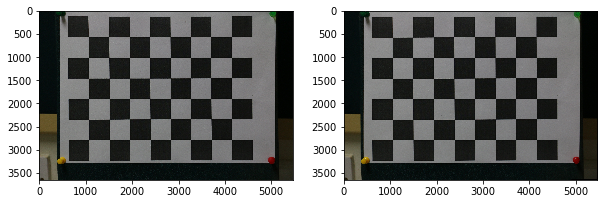

In [239]:
print("             Actual Image                     Undistorted Image")
fig, ax = plt.subplots(1,2)
ax[0].imshow(im)
ax[1].imshow(im_undistorted)
plt.show()

#### Observation
Image taken using camera may have radial distortion, which mean the lines that are straight in real world may not be strain in an image so we undistort the image to get and undistorted image

#### Question 5
Use the real-world measurements that are provided along with the estimated camera parameters to compute the
image of a wireframe of the object. Note that you will be computing the location of image points as $xi = P.Xi$ ,
and not use the image points. Overlay (draw) the wireframe over the actual image of the object using straight
lines between the computed points xi. What do you observe about the overlay?

In [224]:
def draw_wireframe(H, img):
    lst = []
    for j in range(0,73,36):
        for k in range(0,217,36):
            r_p = np.asarray((k,j,0))
            img_point_cons = np.dot(H, np.concatenate((r_p.T, np.ones((1)))))
            img_point_cons = img_point_cons/img_point_cons[2]
            lst.append(img_point_cons)
    for j in range(36,145,36):
        for k in range(0,217,36):
            r_p = np.asarray((k,0,j))
            img_point_cons = np.dot(H, np.concatenate((r_p.T, np.ones((1)))))
            img_point_cons = img_point_cons/img_point_cons[2]
            lst.append(img_point_cons)
    for i in range(len(lst)-1):
        #print(lst[i])
        p1 = tuple(lst[i][:-1].astype(int))
        p2 = tuple(lst[i+1][:-1].astype(int))
        cv2.circle(img, p1, 100, (0,0,255), thickness = 20)
        cv2.line(img, p1, p2,(0,255, 0), thickness=20)

#     cv2.namedWindow('dst', cv2.WINDOW_NORMAL)
#     cv2.imshow('dst',img)
#     if cv2.waitKey(0) & 0xff == 27:
#         cv2.destroyAllWindows()
    return img
    #cv2.imwrite('ovrlay.png',img)

In [225]:
img_cpy = img.copy()
H, _ = ransac_caliberate_matrix(point, value = 0)
img_wireframe = draw_wireframe(H, img_cpy )

/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


             Actual Image              Image with overlay of wireframe


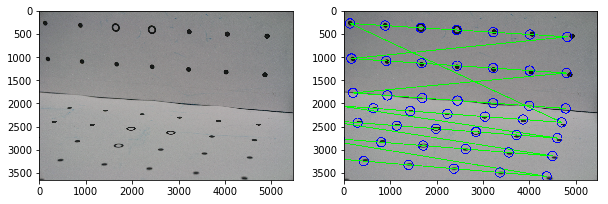

In [240]:
print("             Actual Image              Image with overlay of wireframe")
fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(img_wireframe)
plt.show()

#### Observation
The overlay of wireframe, quite a bit depends on what were the camera parameters so, the wireframe may not always be alighned with the image coordinates

#### Question 6
Repeat the calibration of the camera using Zhangs method using either the available OpenCV or Matlab imple-
mentation. How do your results compare with those of the DLT based method

In [368]:
x,y=np.meshgrid(range(6),range(8))
world_points=np.hstack((y.reshape(48,1),x.reshape(48,1),np.zeros((48,1)))).astype(np.float32)

In [369]:
_3d_points=[]
_2d_points=[]
import pdb
img_paths=glob.glob('data/IMG_*.JPG') #get paths of all all images
for path in img_paths:
    im=cv2.imread(path)
    
    ret, corners = cv2.findChessboardCorners(im, (6,8))
    #print(corners)
    
    if ret:
        _2d_points.append(corners)
        _3d_points.append(world_points)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)

In [380]:
fl3 = [k for l in _3d_points for k in l]
fl3 = [tuple(l) for l in fl3]
fl2 = [k for l in _2d_points for k in l]
fl2 = [list(l) for l in fl2]
fl2 = [tuple(l) for k in fl2 for l in k]
mp = dict(zip(fl3, fl2))

In [382]:
K, R, T, _ = dlt_caliberate_matrix(mp)

/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


In [384]:
print("             Camera Intrinsic parameters from Zhang's method")
print(mtx)
print()
print("             Camera rotational vector from Zhang's method:")
print(rvecs[-1])
print()
print("             Camera translational vector from Zhang's method:")
print(tvecs[-1])
print()
print("             Camera intrinsic parameters from DLT method")
print(K)
print()
print("             Camera rotational matrix from DLT method:")
print(R)
print()
print("             Camera translational vector from DLT method:")
print(T)

             Camera Intrinsic parameters from Zhang's method
[[1.36634814e+04 0.00000000e+00 3.33651176e+03]
 [0.00000000e+00 1.36813888e+04 1.49657920e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

             Camera rotational vector from Zhang's method:
[[ 3.11380294]
 [ 0.05524521]
 [-0.35423022]]

             Camera translational vector from Zhang's method:
[[-5.25702307]
 [ 3.03487287]
 [32.34527809]]

             Camera intrinsic parameters from DLT method
[[ 1.16321814e-13 -3.48965441e-13  2.34080811e+03]
 [-0.00000000e+00 -2.32643628e-13  1.49464478e+03]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]

             Camera rotational matrix from DLT method:
[[ 5.25594580e-01 -8.23005330e-01 -2.15435753e-01]
 [ 1.15643946e-01 -1.81766804e-01  9.76517950e-01]
 [-8.42838546e-01 -5.38166382e-01 -3.60063067e-04]]

             Camera translational vector from DLT method:
[ 3.99290468e+04 -9.50243908e+03  1.00000000e+00]


#### Observation
The camera parameters calculated using Zhang's and DLT method vary a bit depending on coordiantes taken to calculate camera parameters

#### Question 7
Repeat the overlay of wireframe using the internal parameters estimated from Zhangs method. Describe your
observations.

             Actual Image              Image with overlay of wireframe


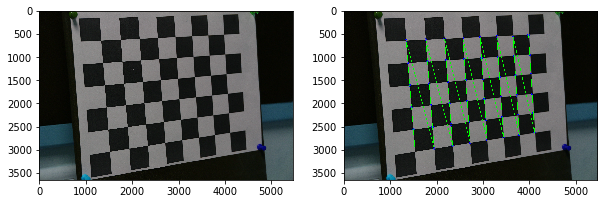

             Actual Image              Image with overlay of wireframe


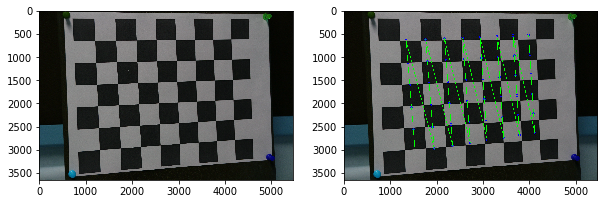

             Actual Image              Image with overlay of wireframe


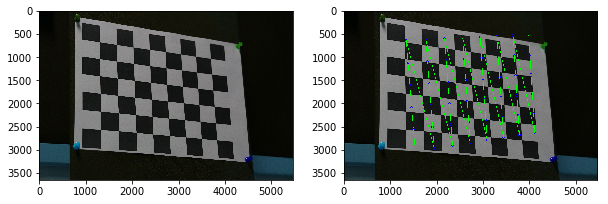

             Actual Image              Image with overlay of wireframe


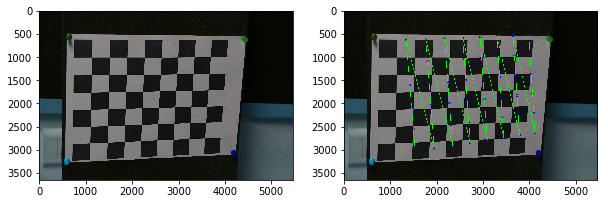

             Actual Image              Image with overlay of wireframe


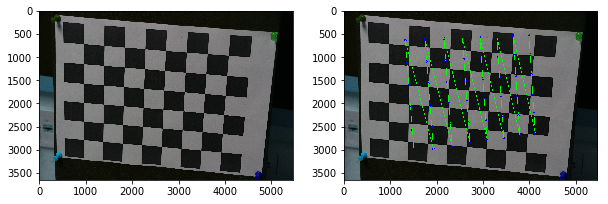

             Actual Image              Image with overlay of wireframe


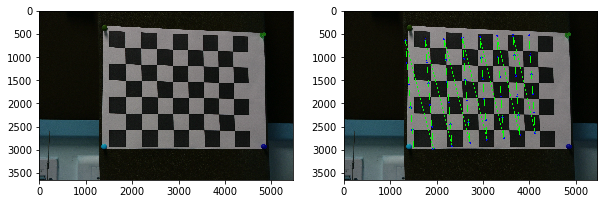

             Actual Image              Image with overlay of wireframe


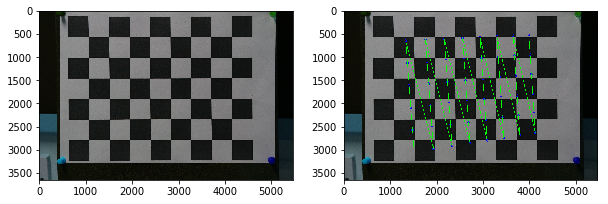

             Actual Image              Image with overlay of wireframe


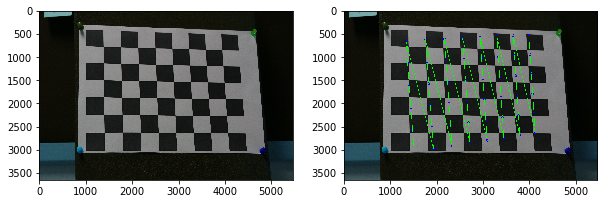

             Actual Image              Image with overlay of wireframe


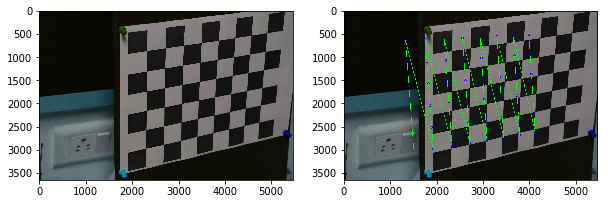

             Actual Image              Image with overlay of wireframe


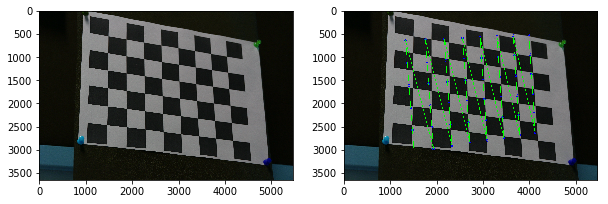

             Actual Image              Image with overlay of wireframe


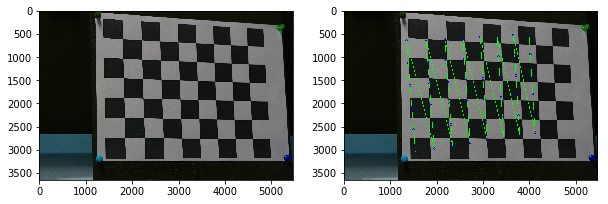

             Actual Image              Image with overlay of wireframe


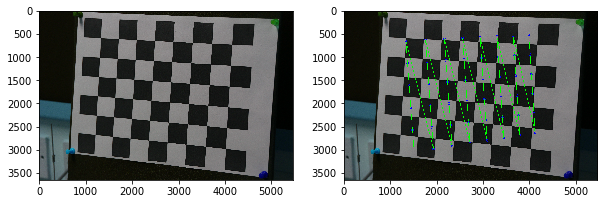

             Actual Image              Image with overlay of wireframe


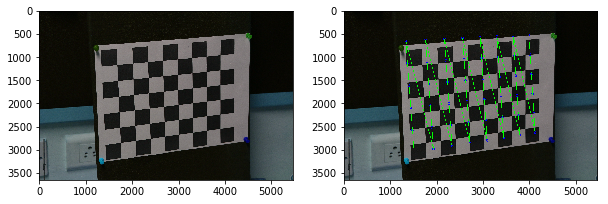

             Actual Image              Image with overlay of wireframe


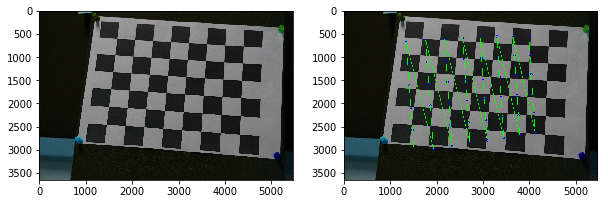

             Actual Image              Image with overlay of wireframe


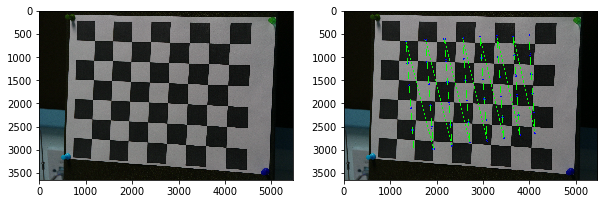

In [306]:
_3d_points=[]
_2d_points=[]
import pdb
img_paths=glob.glob('data/IMG_*.JPG') #get paths of all all images
for path in img_paths:
    im=cv2.imread(path)
    
    ret, corners = cv2.findChessboardCorners(im, (6,8))
    #print(corners)
    
    if ret:
        _2d_points.append(corners)
        _3d_points.append(world_points)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, 
                                                           _2d_points, 
                                                           (im.shape[1],im.shape[0]), None, None)
        im_cp = im.copy()
        img_pt  = []
        R = cv2.Rodrigues(rvecs[0])[0]
        T =tvecs[0]
        RT = np.concatenate((R,T),axis=1)
        P=np.dot(mtx,RT)
        for i in wp:
            ip = np.dot(P, np.concatenate((i.T,np.ones(1))))
            img_pt.append(ip)
        pt = []
        for i in img_pt:
            i = i/i[2]
            pt.append(i)
        for i in range(len(pt)-1):
            p1 = tuple(pt[i][:-1].astype(int))
            p2 = tuple(pt[i+1][:-1].astype(int))
            cv2.circle(im_cp, p1, 20, (0,0,255), thickness = 10)
            cv2.line(im_cp, p1, p2,(0,255, 0), thickness=10)
        print("             Actual Image              Image with overlay of wireframe")
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(im)
        ax[1].imshow(im_cp)
        plt.show()

#### Observation
The overlay of wireframe is more accurate as compared to that of by DLT method

#### Question 8
What is the image of the world origin, given the calibration matrix? Does this result bear out in your observa-
tions?

In [317]:
print("               Image of World Origin is")
print(np.dot(P, [0,0,0,1])/np.dot(P, [0,0,0,1])[2])

               Image of World Origin is
[3.98076210e+03 5.35124662e+02 1.00000000e+00]


#### Question 9
Select a camera that you would like to use for the assignments. Note that you might be using this camera for
future assignments also. This could be your laptop camera, mobile phone camera or any other digital camera
that you have access to.

Image of 3D books stacked together, taken using my camera for DLT based camera caliberation method


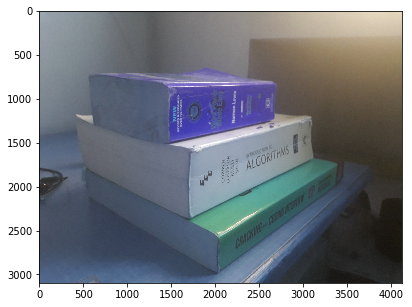

In [398]:
img = cv2.imread('data/20190203_172145.jpg')
plt.imshow(img)
print("Image of 3D books stacked together, taken using my camera for DLT based camera caliberation method")

Image of 3D books stacked together, taken using my camera for Zhang's based camera caliberation method


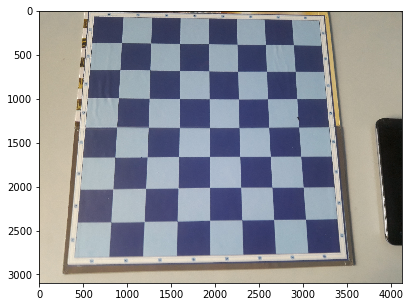

In [399]:
img = cv2.imread('data/20190203_174246.jpg')
plt.imshow(img)
print("Image of 3D books stacked together, taken using my camera for Zhang's based camera caliberation method")

#### Question 10
Repeat the 3 calibration methods using your own camera and your own calibration object for which you measure
and determine the world co-ordinates. Use a printed checkerboard pattern for Zhangs method. Describe and
comment on the results of each method.

In [390]:
point = {}
point[(0,140,-60)] = (1476,870)
point[(165,140,-60)] = (2665,819)
point[(0,92,-60)] = (1467, 1475)
point[(165,92,-60)] = (2683, 1229)
point[(0, 92, -37)] = (1765, 1606)
point[(235, 92, -37)] = (3089, 1229)
point[(0,30,-37)] = (1714, 2355)
point[(235, 30, -37)] = (3125, 1617)
point[(0, 30, 0)] = (2040, 2569)
point[(270, 30, 0)] = ( 347, 1703)
point[(0, 0, 0)] = (2054, 2965)
point[(270,0,0)] = (3443, 1913)

Applying DLT camera caliberation algorithm to an image taken from my camera

In [391]:
K, R, T, _ = dlt_caliberate_matrix(point)

/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


In [392]:
print("             Camera intrinsic parameter:")
print(K)
print()
print("             Camera rotational matrix:")
print(R)
print()
print("             Camera translational vector:")
print(T)

             Camera intrinsic parameter:
[[-9.76588232e-03  8.13626383e+00  3.60420610e+03]
 [-0.00000000e+00  8.16159567e+01  1.65297055e+03]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]

             Camera rotational matrix:
[[ 3.16774559e-04 -8.03418393e-05 -9.99999947e-01]
 [ 4.07522287e-01 -9.13195239e-01  2.02460488e-04]
 [-9.13195207e-01 -4.07522329e-01 -2.56535929e-04]]

             Camera translational vector:
[-4.50257227e+03  7.04299167e+03  1.00000000e+00]


In [393]:
point = {}
point[(0, 0, 0)] = (950, 377)
point[(6, 0, 0)] = (2897, 391)
point[(0, -2, 0)] = (889, 1331)
point[(6, -2, 0)] = (2963, 1331)
point[(0, -4, 0)] = (847, 2039)
point[(6, -4, 0)] = (3014, 2006)

Apply Zhang's method to a chessboard image taken using my camera

In [394]:
_3d_points=[]
_2d_points=[]

im = cv2.imread('data/20190203_174246.jpg')
im = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
for k in point:
    _2d_points.append(point[k])
    _3d_points.append(k)
rp = np.asarray(_3d_points).astype('float32')
ip = np.asarray(_2d_points).astype('float32')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([rp], [ip], (im.shape[1],im.shape[0]), None, None)

In [395]:
print("             Camera intrinsic parameter:")
print(mtx)
print()
print("             Camera rotational vector:")
print(rvecs)
print()
print("             Camera translational vector:")
print(tvecs)

             Camera intrinsic parameter:
[[1.93968431e+03 0.00000000e+00 1.92767998e+03]
 [0.00000000e+00 4.12929342e+03 2.06614079e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

             Camera rotational vector:
[array([[ 2.39586291],
       [-0.00456474],
       [ 0.01053454]])]

             Camera translational vector:
[array([[-2.98760894],
       [-1.82467665],
       [ 7.17807279]])]


#### Challenges faced
- Finding out image coordinates precisily is a bit difficult as a result, the results aren't always accurate
- The real world coordinates calculated depends a lot on how precise the measurement was.
- Clicking pictures that can be used for camera caliberation purpose
- Understanding how opencv functions can be applied to find camera parameters
- Understanding how camera caliberation algorithm can be coded to find the camera parameters

#### Learning Outcome
- Got flexible in using openCV for camera caliberation
- Learnt how to code maths written in various camera caliberation related papers
- Learn how to find the coordinate of an image using openCV